# Demo notebook

In [1]:
from pathlib import Path
import os, json, math, datetime as dt, pathlib
from shapely.geometry import Point, box, mapping
from shapely.ops import transform
from pystac_client import Client
from datetime import datetime, timezone
import requests, tqdm

### S2 data

In [2]:
from s2_data.s2_utils import point_buffer_bbox, get_item_dt_utc, download_asset, plot_s2_truecolor

In [3]:
LAT = 48.3794
LON = 43.1656
DATE = "2024-06-04"
DAYS_BEFORE = 5
DAYS_AFTER  = 5
SEARCH_BUFFER_M = 5000

In [4]:
BASE = Path("data")
S2_DIR   = BASE / "sentinel2"
S2_DIR.mkdir(parents=True, exist_ok=True)

In [5]:
start = (dt.datetime.fromisoformat(DATE) - dt.timedelta(days=DAYS_BEFORE)).date().isoformat()
end   = (dt.datetime.fromisoformat(DATE) + dt.timedelta(days=DAYS_AFTER)).date().isoformat()
time_range = f"{start}/{end}"

print("Time range:", time_range)

Time range: 2024-05-30/2024-06-09


In [6]:
ROI = point_buffer_bbox(LON, LAT, SEARCH_BUFFER_M)
ROI_BBOX = ROI.bounds
ROI_GEOJSON = mapping(ROI)

In [7]:
S2_API = "https://earth-search.aws.element84.com/v1"
S2_COLLECTION = "sentinel-2-l2a"

In [8]:
s2_client = Client.open(S2_API)

In [9]:
s2_search = s2_client.search(
    collections=[S2_COLLECTION],
    datetime=time_range,
    intersects=ROI_GEOJSON,
    limit=20
)

In [10]:
s2_items = list(s2_search.get_items())

s2_items

/Users/martasumyk/Desktop/HyperRes/.venv/lib/python3.12/site-packages/pystac_client/item_search.py:925: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


[<Item id=S2B_37UGP_20240605_0_L2A>,
 <Item id=S2B_38ULU_20240605_0_L2A>,
 <Item id=S2A_37UGP_20240531_0_L2A>,
 <Item id=S2A_38ULU_20240531_0_L2A>]

In [11]:
chosen_date = datetime.fromisoformat(DATE).replace(tzinfo=timezone.utc)


best = sorted(
    s2_items,
    key=lambda it: abs((get_item_dt_utc(it) - chosen_date).total_seconds())
)[0]


In [12]:
best

<Item id=S2B_38ULU_20240605_0_L2A>

In [13]:
assets = best.assets
dl_paths = []

In [14]:
if "visual" in assets:
    href = assets["visual"].href
    out = S2_DIR / f"{best.id}_visual.tif"
    download_asset(href, out)
    dl_paths.append(out)
else:
    for b in ("B04", "B03", "B02"):
        if b in assets:
            href = assets[b].href
            out = S2_DIR / f"{best.id}_{b}.tif"
            download_asset(href, out)
            dl_paths.append(out)

print("Downloaded:", [str(p) for p in dl_paths])

S2B_38ULU_20240605_0_L2A_visual.tif: 100%|██████████| 277M/277M [00:42<00:00, 6.54MB/s] 

Downloaded: ['data/sentinel2/S2B_38ULU_20240605_0_L2A_visual.tif']


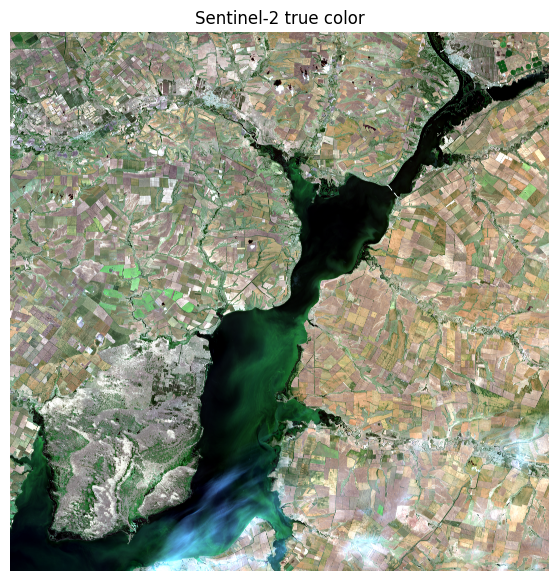

In [15]:
plot_s2_truecolor(dl_paths)